In [3]:
import pandas as pd
import numpy as np


# ------------------- 输入参数 -------------------

input_csv_path = 'EDGE.csv'
output_csv_path = 'EDGE_interpolated.csv'

# 目标频率范围和点数
min_freq = 20.0  # Hz
max_freq = 20000.0 # Hz
num_points = 2000 # 你希望在新文件中包含多少个频率点

# ------------------- 代码实现 -------------------

try:
    # --- 1. 读取数据 ---
    # 如果是从文件读取:
    df_original = pd.read_csv(input_csv_path)

    # 确保列名正确 (假设是 'x' 和 'y')
    if 'X' not in df_original.columns or 'dY' not in df_original.columns:
        raise ValueError("CSV文件需要包含 'dx' (频率) 和 'dy' (响应) 列")

    # 获取原始频率和响应值
    original_freq = df_original['X'].values
    original_resp = df_original['Y'].values

    # 插值函数要求频率必须是单调递增的，我们先排序以确保这一点
    sort_indices = np.argsort(original_freq)
    original_freq = original_freq[sort_indices]
    original_resp = original_resp[sort_indices]

    # --- 2. 确定目标频率点 ---
    # 使用np.logspace在对数尺度上生成等距点
    # np.logspace(start, stop, num) 生成 num 个点，范围从 10**start 到 10**stop
    target_freq = np.logspace(np.log10(min_freq), np.log10(max_freq), num=num_points)

    # --- 3. 插值 ---
    # 使用 numpy.interp 进行插值
    # np.interp(x_new, x_old, y_old)
    # 为了在对数频率轴上进行线性插值，我们对频率取对数
    # 注意：np.interp会自动处理边界情况，如果target_freq超出了original_freq的范围，
    # 它会使用original_resp的第一个或最后一个值。
    #target_resp = np.interp(np.log10(target_freq), np.log10(original_freq), original_resp)

    # （可选）使用 Scipy 进行更高阶插值 (例如三次样条)
    from scipy.interpolate import interp1d
    f_interp = interp1d(np.log10(original_freq), original_resp, kind='cubic', fill_value="extrapolate")
    target_resp = f_interp(np.log10(target_freq))

    # --- 4. 保存结果 ---
    # 创建新的 DataFrame
    df_resampled = pd.DataFrame({'Frequency (Hz)': target_freq, 'Response (dB)': target_resp})

    # 保存到新的 CSV 文件
    df_resampled.to_csv(output_csv_path, index=False, float_format='%.6f') # 使用6位小数精度保存

    print(f"处理完成！已将 {len(df_original)} 个原始数据点插值为 {num_points} 个对数等距频率点。")
    print(f"结果已保存到: {output_csv_path}")

except FileNotFoundError:
    print(f"错误: 输入文件 '{input_csv_path}' 未找到。")
except ValueError as ve:
    print(f"数据错误: {ve}")
except Exception as e:
    print(f"发生意外错误: {e}")



数据错误: CSV文件需要包含 'dx' (频率) 和 'dy' (响应) 列


In [2]:
import matplotlib.pyplot as plt

# 绘制图形
plt.figure(figsize=(10, 6))
plt.plot(df_resampled['Frequency (Hz)'], df_resampled['Response (dB)'], label='Frequency Response')

# 设置 x 轴为对数坐标
plt.xscale('log')

# 添加标题和标签
plt.title('Frequency Response (Logarithmic Scale)', fontsize=14)
plt.xlabel('Frequency (Hz)', fontsize=12)
plt.ylabel('Response (dB)', fontsize=12)

# 添加网格和图例
plt.grid(which='both', linestyle='--', linewidth=0.5)
plt.legend()

# 显示图形
plt.show()

NameError: name 'df_resampled' is not defined

<Figure size 1000x600 with 0 Axes>

In [28]:
import pandas as pd
import numpy as np
from scipy.optimize import minimize
from scipy.signal import freqs as signal_freqs  # Correct import for frequency response of filters
import plistlib
import math
import os

# --- Configuration ---
HEADPHONE_FILE = 'CH720N_logSpaced_frequencyResponse.csv'
TARGET_FILE = 'Harman over-ear 2018.csv' # <-- Make sure you have this file!
OUTPUT_PRESET_NAME = 'EDGE Harman Correction'
OUTPUT_PRESET_FILENAME = 'CH720N_Harman_Correction.aupreset'


NUM_EQ_BANDS = 32  # Standard Apple AUPeakEQ has 10 bands
MIN_FREQ = 20.0
MAX_FREQ = 20000.0

# EQ Parameter Bounds (Adjust if needed)
FREQ_BOUNDS = (MIN_FREQ, MAX_FREQ)
GAIN_BOUNDS = (-18.0, 18.0) # Limit gain to reasonable values
Q_BOUNDS = (0.1, 10.0)    # Q factor range

# --- Helper Functions ---

def load_csv_data(filepath, freq_col=0, db_col=1):
    """Loads frequency response data from CSV."""
    try:
        df = pd.read_csv(filepath, header=None, skiprows=1, usecols=[freq_col, db_col],
                         names=['frequency', 'db'], comment='#') # Skip header, handle comments
        # Sometimes data might have non-numeric entries, try converting, drop errors
        df['frequency'] = pd.to_numeric(df['frequency'], errors='coerce')
        df['db'] = pd.to_numeric(df['db'], errors='coerce')
        df = df.dropna()
        df = df.sort_values(by='frequency').drop_duplicates(subset=['frequency'])
        # Ensure data starts at or before MIN_FREQ and ends at or after MAX_FREQ for interpolation
        if df['frequency'].iloc[0] > MIN_FREQ:
             df = pd.concat([pd.DataFrame({'frequency': [MIN_FREQ], 'db': [df['db'].iloc[0]]}), df], ignore_index=True)
        if df['frequency'].iloc[-1] < MAX_FREQ:
             df = pd.concat([df, pd.DataFrame({'frequency': [MAX_FREQ], 'db': [df['db'].iloc[-1]]})], ignore_index=True)

        return df['frequency'].values, df['db'].values
    except FileNotFoundError:
        print(f"Error: File not found at {filepath}")
        return None, None
    except Exception as e:
        print(f"Error loading {filepath}: {e}")
        return None, None

def peaking_filter_tf(f, f0, G_db, Q):
    """
    Calculates the transfer function magnitude (in dB) of a digital peaking filter.
    Uses the bilinear transform approximation, assumes fs=44100Hz (or higher).
    Accuracy is generally good for audio frequencies away from Nyquist.
    """
    A = 10**(G_db / 40)
    w0 = 2 * np.pi * f0
    # Simulate with a high sample rate to minimize digital cramping at high frequencies
    # Using scipy.signal.freqs which works with analog prototypes is simpler here
    # Convert peaking EQ parameters to analog prototype coefficients
    # Note: This is an approximation, precise digital filter dB response is more complex
    alpha = np.sin(w0 / (2 * Q)) # Approximation assuming fs is high enough

    # Coefficients for analog prototype peaking filter (approximated)
    # This requires a proper mapping from digital filter specs to analog
    # Let's use a direct dB calculation approach for simplicity in optimization

    # --- Direct dB Calculation (Approximation) ---
    # Based on common EQ gain formulas
    omega = 2 * np.pi * f
    omega0 = 2 * np.pi * f0

    # Simplified formula often used (accuracy varies with Q and freq)
    # Avoid division by zero or negative sqrt
    f_ratio = f / f0
    term = (f_ratio**2 - 1)**2 + (f_ratio / Q)**2
    # Avoid math errors at f=0 or with invalid inputs
    term = np.where(term <= 0, 1e-12, term)
    
    # Gain calculation needs care - different formulas exist.
    # Let's use a standard definition related to analog prototypes:
    # H(s) = (s^2 + s*(A*w0/Q) + w0^2) / (s^2 + s*(w0/(A*Q)) + w0^2) for boost
    # H(s) = (s^2 + s*(A*w0/Q) + w0^2) / (s^2 + s*(w0/(A*Q)) + w0^2) for cut (inverted A?)
    # This gets complex quickly. Let's use a simpler widely cited approximation:

    # Magnitude squared approximation:
    if G_db >= 0: # Boost
        A_lin = 10**(G_db / 20.0)
        num = (omega**2 - omega0**2)**2 + (omega * omega0 / Q * A_lin)**2
        den = (omega**2 - omega0**2)**2 + (omega * omega0 / Q / A_lin)**2
    else: # Cut
        A_lin = 10**(-G_db / 20.0) # Invert gain for cut formula
        den = (omega**2 - omega0**2)**2 + (omega * omega0 / Q * A_lin)**2
        num = (omega**2 - omega0**2)**2 + (omega * omega0 / Q / A_lin)**2

    # Prevent division by zero if den is somehow zero
    den = np.where(den == 0, 1e-12, den)
    mag_sq = num / den
    mag_sq = np.where(mag_sq < 0, 0, mag_sq) # Ensure non-negative

    # Convert magnitude squared to dB
    # Add small epsilon to avoid log10(0)
    db = 10 * np.log10(mag_sq + 1e-18)
    return db


def total_eq_response(frequencies, params, num_bands):
    """Calculates the combined response of all EQ bands."""
    total_db = np.zeros_like(frequencies, dtype=float)
    # Params are flat: [f1, g1, q1, f2, g2, q2, ...]
    for i in range(num_bands):
        f0 = params[i * 3]
        gain_db = params[i * 3 + 1]
        q = params[i * 3 + 2]
        # Ensure parameters are within reasonable bounds during calculation
        f0 = np.clip(f0, FREQ_BOUNDS[0], FREQ_BOUNDS[1])
        gain_db = np.clip(gain_db, GAIN_BOUNDS[0], GAIN_BOUNDS[1])
        q = np.clip(q, Q_BOUNDS[0], Q_BOUNDS[1])
        total_db += peaking_filter_tf(frequencies, f0, gain_db, q)
    return total_db

def error_function(params, target_db, frequencies, num_bands):
    """Error function for optimization (RMSE)."""
    eq_db = total_eq_response(frequencies, params, num_bands)
    error = np.sqrt(np.mean((eq_db - target_db)**2))
    return error

def generate_aupreset_plist(params, preamp_gain_db, preset_name, num_bands):
    """Generates the plist structure for the .aupreset file."""
    # Base structure for Apple AUPeakEQ
    plist_dict = {
        'manufacturer': 1634758764,  # 'appl'
        'type': 1635083896,          # 'aufc' (AudioUnit Filter) - Sometimes seen as 'aumf' or 'aurg' too
        'subtype': 1886282097,       # 'pmeq' (Parametric EQ)
        'version': 0,
        'name': preset_name,
        'data': {
            # Parameter keys for AUPeakEQ (confirm by saving a manual preset)
            # Key 0 is often global gain (preamp)
            # Bands usually start at index 1000, 2000, etc.
            0: float(preamp_gain_db) # Global Gain / Preamp
        }
    }

    param_idx = 1000 # Starting index for Band 1 parameters
    for i in range(num_bands):
        f0 = float(np.clip(params[i * 3], FREQ_BOUNDS[0], FREQ_BOUNDS[1]))
        gain_db = float(np.clip(params[i * 3 + 1], GAIN_BOUNDS[0], GAIN_BOUNDS[1]))
        q = float(np.clip(params[i * 3 + 2], Q_BOUNDS[0], Q_BOUNDS[1]))

        plist_dict['data'][param_idx] = f0     # Frequency
        plist_dict['data'][param_idx + 1] = gain_db # Gain
        plist_dict['data'][param_idx + 2] = q      # Q

        param_idx += 1000 # Move to next band's parameter index block

    # Add bypass state (0 = not bypassed)
    plist_dict['data']['bypass'] = 0

    return plist_dict

# --- Main Script ---

# 1. Load Data
print(f"Loading headphone data from: {HEADPHONE_FILE}")
headphone_freq, headphone_db = load_csv_data(HEADPHONE_FILE, freq_col=0, db_col=1)
if headphone_freq is None: exit()

print(f"Loading target curve from: {TARGET_FILE}")
target_freq_raw, target_db_raw = load_csv_data(TARGET_FILE, freq_col=0, db_col=1) # Adjust col indices if needed
if target_freq_raw is None: exit()
# Normalize headphone frequency response to 0 dB at 1 kHz
print("Normalizing headphone frequency response...")
reference_freq = 1000.0  # Reference frequency for normalization (1 kHz)
# Find the closest index to the reference frequency
ref_index = np.argmin(np.abs(headphone_freq - reference_freq))
# Calculate the normalization offset
normalization_offset = headphone_db[ref_index]
# Apply normalization
headphone_db -= normalization_offset
print(f"Normalized headphone response by offset: {normalization_offset:.2f} dB")
# 2. Align Data (Interpolate Target to Headphone Frequencies)
print("Interpolating target curve onto headphone frequency points...")
# Use log interpolation for frequency response
target_db_interp = np.interp(
    np.log10(headphone_freq),
    np.log10(target_freq_raw),
    target_db_raw
)

# 3. Calculate Correction Curve
correction_db = target_db_interp - headphone_db

# 4. Calculate and Apply Preamp Gain
# Preamp gain should be the negative of the maximum boost required, or 0 if only cuts are needed
max_boost = np.max(correction_db)
preamp_gain = 0.0
if max_boost > 0:
    preamp_gain = -max_boost
    print(f"Applying preamp gain of: {preamp_gain:.2f} dB")
else:
    print("No positive boost needed, preamp gain set to 0 dB.")

# Adjust the target correction curve by the preamp gain
target_correction_for_eq = correction_db + preamp_gain

# 5. Fit Parametric EQ using Optimization

# Initial guess for EQ parameters (log-spaced frequencies, 0 gain, moderate Q)
initial_freqs = np.logspace(np.log10(MIN_FREQ * 1.5), np.log10(MAX_FREQ * 0.75), NUM_EQ_BANDS) # Spread out, avoid extremes initially
initial_gains = np.zeros(NUM_EQ_BANDS)
initial_qs = np.full(NUM_EQ_BANDS, 1.41) # Default Q often around sqrt(2)

initial_params = []
for i in range(NUM_EQ_BANDS):
    initial_params.extend([initial_freqs[i], initial_gains[i], initial_qs[i]])

# Parameter bounds for the optimizer ([ (f_min, f_max), (g_min, g_max), (q_min, q_max), ... ])
bounds = []
for _ in range(NUM_EQ_BANDS):
    bounds.extend([FREQ_BOUNDS, GAIN_BOUNDS, Q_BOUNDS])

print(f"Optimizing {NUM_EQ_BANDS} parametric EQ bands...")
# Use L-BFGS-B optimizer which handles bounds
result = minimize(
    error_function,
    initial_params,
    args=(target_correction_for_eq, headphone_freq, NUM_EQ_BANDS),
    method='L-BFGS-B',
    bounds=bounds,
    options={'maxiter': 500, 'ftol': 1e-7, 'disp': False} # Increase maxiter if needed
)

if not result.success:
    print(f"Warning: Optimization might not have converged fully. Message: {result.message}")
else:
    print(f"Optimization successful. Final error (RMSE): {result.fun:.4f} dB")

optimized_params = result.x


Loading headphone data from: CH720N_logSpaced_frequencyResponse.csv
Loading target curve from: Harman over-ear 2018.csv
Normalizing headphone frequency response...
Normalized headphone response by offset: 94.37 dB
Interpolating target curve onto headphone frequency points...
Applying preamp gain of: -24.76 dB
Optimizing 32 parametric EQ bands...


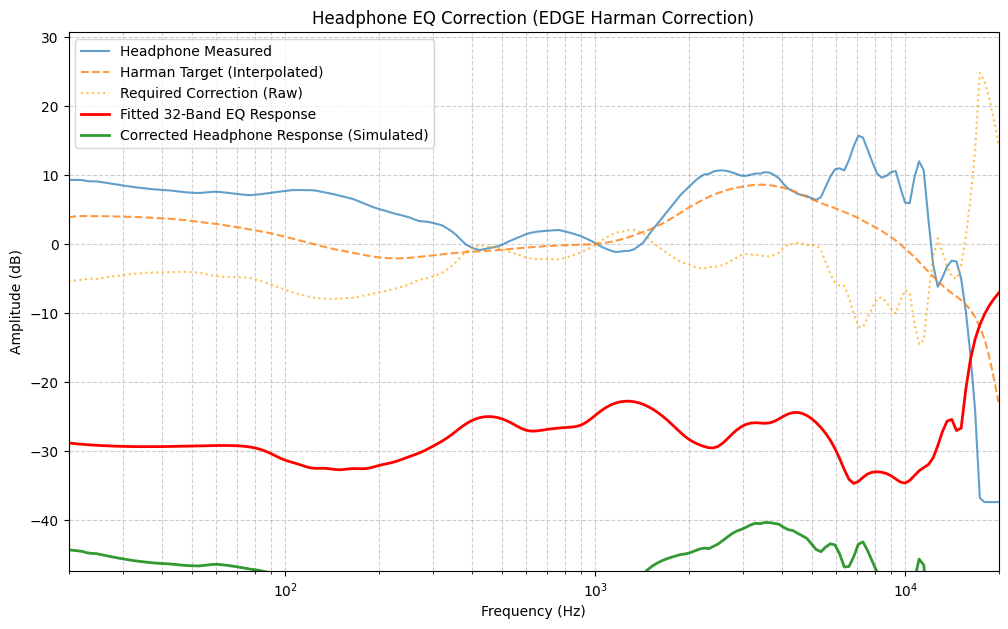

In [29]:
try:
    import matplotlib.pyplot as plt
    plt.figure(figsize=(12, 7))
    plt.semilogx(headphone_freq, headphone_db, label='Headphone Measured', alpha=0.7)
    plt.semilogx(headphone_freq, target_db_interp, label='Harman Target (Interpolated)', linestyle='--', alpha=0.8)
    plt.semilogx(headphone_freq, correction_db, label='Required Correction (Raw)', linestyle=':', color='orange', alpha=0.7)
    # Calculate the actual response of the generated EQ filters
    final_eq_response = total_eq_response(headphone_freq, optimized_params, NUM_EQ_BANDS)
    plt.semilogx(headphone_freq, final_eq_response, label=f'Fitted {NUM_EQ_BANDS}-Band EQ Response', color='red', linewidth=2)
    plt.semilogx(headphone_freq, headphone_db + final_eq_response + preamp_gain, label='Corrected Headphone Response (Simulated)', color='green', linewidth=2, alpha=0.8)
    plt.title(f'Headphone EQ Correction ({OUTPUT_PRESET_NAME})')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Amplitude (dB)')
    plt.legend()
    plt.grid(which='both', linestyle='--', alpha=0.6)
    plt.xlim(MIN_FREQ, MAX_FREQ)
    plt.ylim(min(np.min(headphone_db), np.min(target_db_interp)) - 10, max(np.max(headphone_db), np.max(target_db_interp)) + 15) # Adjust y-lims
    plt.show()
except ImportError:
    print("\nMatplotlib not installed. Skipping plot generation.")
except Exception as e:
    print(f"\nError generating plot: {e}")


In [31]:
def save_eq_profile(params, preamp_gain, output_file="EQ-Profile.txt"):
    """
    将优化后的EQ参数保存为标准格式的文本文件
    params: 优化后的参数数组 [f1, g1, q1, f2, g2, q2, ...]
    preamp_gain: 前置增益值
    output_file: 输出文件名
    """
    with open(output_file, "w") as f:
        # 写入前置增益
        f.write(f"Preamp: {preamp_gain:.1f} dB\n")
        
        # 写入每个滤波器的参数
        for i in range(NUM_EQ_BANDS):
            freq = params[i * 3]
            gain = params[i * 3 + 1]
            q = params[i * 3 + 2]
            
            # 格式化输出，保持与示例一致的格式
            f.write(f"Filter {i+1}: ON PK Fc {freq:.0f} Hz Gain {gain:.1f} dB Q {q:.2f}\n")
    
    print(f"EQ配置文件已保存至: {output_file}")


save_eq_profile(optimized_params, preamp_gain, "CH720N-EQ-Profile.txt")


EQ配置文件已保存至: CH720N-EQ-Profile.txt
